# Морфология 2
В данном ноутбуке находится задание на триграммы и словарь. В качестве текста будем использовать томик войны и мира: https://goo.gl/qcVTLE 

Для начала напомним некоторые полезные инструменты на питоне

## 1. Инструменты

### 1.1. Регулярные выражения
Исчерпывающий пост https://habr.com/ru/post/349860/

In [2]:
import re

# С помощью рег. выражения можно искать, заменять и сентезировать строки по шаблонам
# Парочка простых примеров
numbers = re.findall(r'\d+', r'There is some numbers: 49 and 432')
print('Находим числа в строке: ', numbers)

print('Простенький токенизатор: ', re.sub('[,\.?!]',' ','How, to? split. text!').split())

print('Еще один токенизатор: ', re.split(r'\W+', 'How, to? split. text! Again'))

# в качестве тренировки придумайте свой токенизатор в случае, когда из текста нужно получить только русские слова.

Находим числа в строке:  ['49', '432']
Простенький токенизатор:  ['How', 'to', 'split', 'text']
Еще один токенизатор:  ['How', 'to', 'split', 'text', 'Again']


In [70]:
# для только русских слов 
print('Еще один токенизатор: ', re.findall(r'[а-я,А-Я,ёЁ]+', 'Здравствуй, дорогой  друг! How are you поживаешь?'))

Еще один токенизатор:  ['Здравствуй,', 'дорогой', 'друг', 'поживаешь']


### 1.2. Чтение файлов
Чтобы не мучится самим с кодировками, приведем способ чтения файла корпуса.

In [4]:
import io

text_file_path = 'war_and_peace.txt'
wordlist = None

with io.open(text_file_path, "r", errors='ignore') as text_file:
    text = text_file.read()
    wordlist = re.split(r'\W+', text.lower())
    # wordlist = Здесь заиспользуем токенизатор. Также приведем все слова к нижнему регистру.
print(len(wordlist))
print(wordlist[:10])

111091
['лев', 'николаевич', 'толстой', 'война', 'и', 'мир', 'том', '1', 'часть', 'первая']


### 1.3. ООП
В питоне можно создавать свои классы, скорее всего нам понадобится класс для хранения бора

In [48]:
class Node:
    def __init__(self):
        '''
        Simple constructor without params
        '''
        self.to = dict()
        self.count = 0
    
    
class Trie:
    def __init__(self):
        self.nodes = [Node()]
        
    def add_word(self, word):
        v = 0
        
        for c in word:
            if c not in self.nodes[v].to:
                self.nodes[v].to = len(self.nodes)
                self.nodes.append(Node())
            v = self.nodes[v].to[c]
    
    def get_node(self, word):
        v = 0
        
        for c in word:
            if c not in self.nodes[v].to:
                return -1
            v = self.nodes[v].to[c]
        self.nodes[v].count += 1
            
    def get_best_continuation(self, v, steps=2):
        if steps == 0:
            return "", self.nodes[v].count
        
        best_count = self.node[v].count
        best_chars = ""
        
        for c, to in self.nodes[v].to:
            cur_count, cur_chars = self.get_best_continuation(to, steps-1)
            if cur_count > best_count:
                best_count = cur_count
                best_chars = c + cur_chars
        return best_count, best_chars
        
    
# все данные хранятся в self, поэтому он и передается первым аргументом во все методы

### 1.4. pyplot
Довольно часто приходится построить какие-нибудт графики и гистограммы для изучения данных, с которыми придется работать. Для этого в питоне есть удобнейший модуль для этого - pyplot. Туториал: https://matplotlib.org/3.1.1/tutorials/introductory/pyplot.html

In [6]:
#!pip install matplotlib # Установка модуля
import matplotlib.pyplot as plt
# команда чтобы картинки рисовались прямо в ноутбуке
%matplotlib inline 

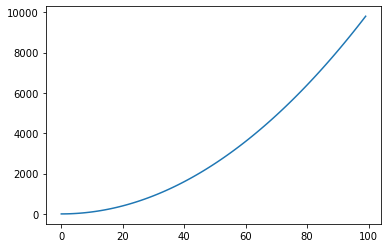

In [7]:
# Посмотрим на график функции x^2
data = [i * i for i in range(100)]
plt.plot(data)

(array([32., 13., 10.,  8.,  8.,  6.,  6.,  6.,  5.,  6.]),
 array([   0. ,  980.1, 1960.2, 2940.3, 3920.4, 4900.5, 5880.6, 6860.7,
        7840.8, 8820.9, 9801. ]),
 <a list of 10 Patch objects>)

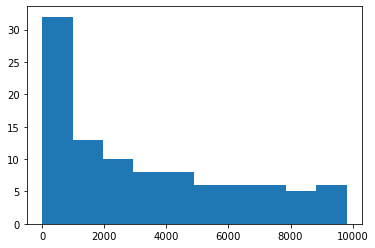

In [8]:
# и распределение по значениям
plt.hist(data)

Также полезная команда для подсчета времения выполнеия в ячейке

In [9]:
%%time
res = 0
for i in range(int(1e8)):
    res += 1

CPU times: user 6.93 s, sys: 1.13 ms, total: 6.93 s
Wall time: 6.93 s


## 2. Задание
Собственно теперь нам потребуется написать подсчет триграмм и бор для словаря, чтобы реализовать простенькую систему исправления ошибок.

### 2.1. Триграммы
Для начала получим словарь триграмма - её кол-во в тексте, не забывая о начале и конце слова.

Далее можно построить гистограмму на кол-во вхождений триграмм, и посмотреть самые частые и какая частота у каких-нибудь заведомо странных, например: 'чгк', 'шкя' и подобные. Из полученных данных придумать эвристику, как считать слово с опечаткой. Проверить эвристику по словарю.

In [57]:
from collections import Counter

def word_trigrams(word):
    result = []
    
    for char_id in range(len(word)):
        if char_id < 2:
            result.append('#' * (2-char_id) + word[:char_id+1])
        else:
            result.append(word[char_id-2:char_id+1])
    if len(word) > 1:
        result.append('#' + word[-2:])    
    if len(word):
        result.append('##' + word[-1])
    return result

def corpus_trigrams(word_list):
    '''returns trigrams count dictionary'''
    
    counter = Counter()
    for word in word_list:
        for trigram in word_trigrams(word):
            counter[trigram] += 1
    return counter

Посмотрим на распределение частот триграм и вероятности наиболее странных из них.

In [58]:
trigram_dict = corpus_trigrams(wordlist)

In [59]:
trigram_dict.most_common(10)

[('##о', 21455),
 ('##и', 18237),
 ('##в', 13538),
 ('##а', 12571),
 ('##е', 12514),
 ('##н', 12320),
 ('##с', 11837),
 ('##к', 10231),
 ('##п', 9830),
 ('##м', 8373)]

(array([7.268e+03, 3.840e+02, 1.120e+02, 6.100e+01, 3.000e+01, 2.400e+01,
        2.000e+01, 1.500e+01, 6.000e+00, 8.000e+00]),
 array([1.0000e+00, 1.9740e+02, 3.9380e+02, 5.9020e+02, 7.8660e+02,
        9.8300e+02, 1.1794e+03, 1.3758e+03, 1.5722e+03, 1.7686e+03,
        1.9650e+03]),
 <a list of 10 Patch objects>)

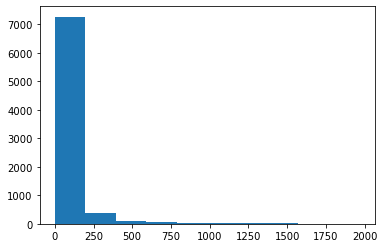

In [60]:
plt.hist([x for x in trigram_dict.values() if x <= 2000], bins=10)

Идея: считать, что слова, содержащие хотя бы одну очень редкую триграмму, написаны с ошибкой. 

In [61]:
for threshold in [1, 5, 10]:
    print(f'Доля триграмм, встречающихся <= {threshold} раз')
    print(len([trigram for trigram, count in trigram_dict.items() if count <= threshold]) / len(trigram_dict))

Доля триграмм, встречающихся <= 1 раз
0.17210235825388862
Доля триграмм, встречающихся <= 5 раз
0.39877069744104365
Доля триграмм, встречающихся <= 10 раз
0.5163070747616658


Можно увидеть, что очень редких триграмм (встречающихся менее 1 раза) около 19%. Значит, будем считать, что написано с ошибкой только в случае, если какая-то из его триграмм встречается в тексте <= 1 раза.

In [62]:
print(trigram_dict['чгк'])
print(trigram_dict['шкя'])
print(trigram_dict['съе'])
print(trigram_dict['еее'])
print(trigram_dict['лол'])
print(trigram_dict['кек'])

0
0
8
0
3
0


In [63]:
def is_error(word):
    '''is the word with mistake'''
    trigrams = word_trigrams(word)
    print(trigrams)
    return any(trigram_dict[trigram] <= 1 for trigram in trigrams)

In [64]:
print(is_error('привет'))
print(is_error('лол'))
print(is_error('кек'))

['##п', '#пр', 'при', 'рив', 'иве', 'вет', '#ет', '##т']
False
['##л', '#ло', 'лол', '#ол', '##л']
False
['##к', '#ке', 'кек', '#ек', '##к']
True


### 2.2. Бор
Далее построим бор, с помощью которого будем искать исправления опечатки в слове. Пока только в случае замены и удаления в конце (Если есть желание, то можно и для всех случаев). Также сравнить по времени с поиском в случае замены в исходном слове последних двух символов и поиске в словаре.

In [ ]:
def correct_word(word):
    '''returns most similar word from dictionary'''
    if len(word) <= 1:
        for ch in range('а', 'я'+1):
            if ch in all_word_dict:
                return ch
    for ch1 in range('а', 'я'+1):
        for ch2 in range('а', 'я'+1):
            new_word = word[:-2] + ch1 + ch2
            if new_word in all_word_dict:
                return new_word
    
def correct_word_naive(word):
    '''correct word using generation'''
    return trie.get_best_continuation(trie.get_node(word[:-2]))

### 2.3 Все вместе
Теперь соберем поиск и исправление опечаток в одну систему, которая будет принимать текст и править его. Также замерим скорость по сравнению с "менее наивным подходом".

In [ ]:
def correct_mistakes(text):
    '''returns corrected text'''
    return ' '.join([for word in text.split() correct_word(word) if is_error(word) else word])

def correct_mistakes_naive(text):
    '''returns corrected text using generation'''
    return ' '.join([for word in text.split() correct_word_naive(word) if is_error(word) else word])